In [1]:
%matplotlib widget
# %matplotlib inline

import numpy as np
import cmath
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import kvn
import pylib.qucf_read as qucf_r
import pylib.measurement as mse
import LCHS

12556
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# ---------------------------------------------------------------------------------------------------
# --- Some global parameters ---
# ---------------------------------------------------------------------------------------------------
colors_ = ["b", "r", "g", "magenta", "black"]
for _ in range(100):
    plt.close()

In [3]:
# ---------------------------------------------------------------------------------------------------
# --- Prepare intial parameters ---
# CL   - classical (simulations)
# QuCF - framework used for quantum computations
# LCHS - Linear Combination of Hamiltonian Simulations
# ---------------------------------------------------------------------------------------------------
mix.reload_module(kvn)

# --- two attractors ---
F_ = lambda x:  - np.sin(x) * (np.sin(x)**2 - 0.25) 
t_max, x_max = 4.0, 1
# ----------------------------------------

nx_ = 7
# nt_ = 14

print("nx: {:d}".format(nx_))
# print("nt: {:d}".format(nt_))
print()

# # --- Time grid ---
# Nt = 1<<nt_
# t = np.linspace(0,t_max,Nt)
# dt = np.diff(t)[0]             # time step for CL simulations

# --- Linear x-grid ---
Nx_ = 1 << nx_
x_ = np.linspace(-x_max, x_max, Nx_)  
# dx_    = np.diff(x_)[0]

# --- Hermitian and anti-Hermitian parts of i*H ---
print("\n--- UPWINDING DIFFERENCE SCHEME ---")
H_UW_, Aa_, Ah_, _, _ = kvn.construct_UW_matrix_1D(x_, F_, flag_asin = False)
print()
print("Aa.Ah - Ah.Aa: {:20.3e}".format(np.max(Ah_.dot(Aa_) - Aa_.dot(Ah_))))

_, norm_Ah_, _ = mix.compute_normalized_matrix(Ah_, "Ah", True)
_, norm_Aa_, _ = mix.compute_normalized_matrix(Aa_, "Aa", True)

nx: 7


--- UPWINDING DIFFERENCE SCHEME ---

Aa.Ah - Ah.Aa: 0.000e+00+2.377e+01j
Matrix Ah:	 nonsparsity, coefnorm: 3, 8.622e+01
Matrix Aa:	 nonsparsity, coefnorm: 2, 3.319e+01


In [8]:
# ---------------------------------------------------------------------
# --- Reference classical simulation of the KvN system---
# ---------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)
mix.reload_module(LCHS)
from scipy.linalg import expm
def get_ref_qsp(sel_matrix):
    psi_init_ = np.ones(Nx_) * 2**(-nx_/2.)

    Nt = 10
    t_step = 0.01
    k_max_, nk_init_, n_dk_ = 40.968, 7, 0

    Bh, Ba = kvn.get_herm_aherm_parts(1j * H_UW_)
    dk_ = LCHS.get_dk(None, None, None, n_dk=n_dk_)

    if sel_matrix == "Ba":
        Prop_ch = - 1.j * Nt * t_step/2. * Ba

    if sel_matrix == "Bm":
        Prop_ch = 1.j * Nt * t_step * k_max_ *Bh

    if sel_matrix == "Bk":
        Prop_ch = - 1.j * Nt * t_step * dk_ * Bh

    exp_ch = expm(Prop_ch)
    psi_ref = exp_ch.dot(psi_init_)
    return psi_ref

# --------------------------------------------------
def get_ref_selector():
    psi_init_ = np.ones(Nx_) * 2**(-nx_/2.)

    t_step = 0.01
    k_max_, nk_init_, n_dk_ = 40.968, 7, 0
    nk = nk_init_ + n_dk_
    Nk = 1 << nk

    Bh, Ba = kvn.get_herm_aherm_parts(1j * H_UW_)
    dk_ = LCHS.get_dk(None, None, None, n_dk=n_dk_)

    N = Bh.shape[0]

    exp_LCHS = np.zeros((N,N), dtype=complex)
    for ik in range(Nk):
        Prop_k = -1.j * t_step * (ik * dk_) * Bh
        exp_k = expm(Prop_k)
        exp_LCHS += exp_k
    psi_ref = exp_LCHS.dot(psi_init_)
    return psi_ref

# --------------------------------------------------
# psi_ref_ = get_ref_qsp(sel_matrix = "Bk")
psi_ref_ = get_ref_selector()

Reading the file /media/work/docs/codes/QuCF/QuCF/simulations/LCHS/KvN/test-qsp//nk7_OUTPUT.hdf5...
Name of the simulation is test
Simulation has been performed  07-09-2024 09:37:07


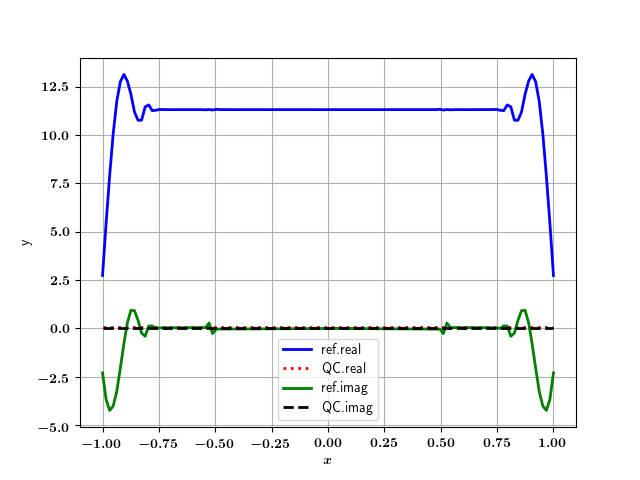

In [9]:
# ---------------------------------------------------------
# --- Compare with QuCF simulations: QSP simulations ---
# ---------------------------------------------------------
def get_qucf_data(path_qc, name_pr):
    om = mse.MeasOracle__()
    om.path_  = path_qc
    om.pname_ = name_pr
    om.open()
    om.set_zero_ancillae_work_states(0)
    qc_state = om.get_var_x({}, "rx")
    return qc_state
# ---------------------------------------------------------
# y_reco_ = get_qucf_data(
#     "/media/work/docs/codes/QuCF/QuCF/simulations/LCHS/KvN/test-qsp/",
#     "test"
# )
y_reco_ = get_qucf_data(
    "/media/work/docs/codes/QuCF/QuCF/simulations/LCHS/KvN/test-qsp/",
    "nk7"
)


# --- Comparison ---
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_, psi_ref_.real,  "-b", linewidth = 2, label = "ref.real")
ax.plot(x_, y_reco_.real,   ":r", linewidth = 2, label = "QC.real")

ax.plot(x_, psi_ref_.imag,  "-g", linewidth = 2, label = "ref.imag")
ax.plot(x_, y_reco_.imag,   "--", color = "black", linewidth = 2, label = "QC.imag")

plt.xlabel('$x$')
plt.ylabel("y")
ax.legend()
plt.grid(True)
plt.show()